# Prelude: Imports and Definitions

In [1]:
import networkx as nx
import pickle
import numpy as np

# Set the directory for local pickle files
PICKLE_DIR = "pickle_files"

# Set the directory to downloads
DOWNLOADS_DIR = "downloads"

RANDOM_STATE = 42


# Prelude: Building the Network

Contains the following:
1. Imports and defining helper functions
2. Scraping data from wikipedia and downloads it
3. Building the network either from
    - (A) Downloaded files
    - (B) Local pickle file (created from last time A was run)
4. Simple prelimenary data analysis of network

In [ ]:
import shutil
import os
from wiki_utils import getJsonResponse, findLinks, build_graph_from_files
if not os.path.exists(PICKLE_DIR):
		os.makedirs(PICKLE_DIR)

## 2. Scraping data
Fetches philosopher data from their wikipedia pages and downloads the wikipedia pages as `{philosopher_name}.txt` in a `downloads/` directory.

>**NOTES**
> 1. This takes a while to run
> 2. It deletes all previous content in `downloads`
> 3. Downloads all pages but skips pages with *no content* or *redirects*.

In [3]:
wiki_links = ["List of philosophers (A–C)", "List of philosophers (D–H)", "List of philosophers (I–Q)", "List of philosophers (R–Z)"]
title_links = []

verbose = False # Debug output during loops
invalid_links = []  # Track titles that could not be saved
redirect_links = []  # Track titles that are redirects

# Delete and recreate the downloads directory
if os.path.exists(DOWNLOADS_DIR):
	shutil.rmtree(DOWNLOADS_DIR)  # Delete the directory and all its contents
os.makedirs(DOWNLOADS_DIR, exist_ok=True)  # Recreate the directory


for wiki_link in wiki_links:
  wiki_markup = getJsonResponse(wiki_link)
  title_links.extend(findLinks(wiki_markup))

# Remove irrelevant links if they exist
for unwanted in ["List_of_philosophers", "Philosopher", "Stanford_Encyclopedia_of_Philosophy", "Encyclopedia_of_Philosophy", "Routledge_Encyclopedia_of_Philosophy", "The_Cambridge_Dictionary_of_Philosophy", "The_Oxford_Companion_to_Philosophy"]:
	if unwanted in title_links:
		title_links.remove(unwanted)

# Writing to files (warning this takes a while)
for title_link in title_links:
	all_wikitext = getJsonResponse(title_link)
	if not all_wikitext:
		if verbose: print(f"Skipping '{title_link}' as it has no content.")
		invalid_links.append(title_link)  # Track invalid pages without modifying the list directly
		continue
  
  # Skip if the content starts with #REDIRECT
	if all_wikitext.strip().startswith("#REDIRECT"):
		if verbose: print(f"Skipping '{title_link}' as it is a redirect.")
		redirect_links.append(title_link)  # Track redirect pages
		continue
  
	filename = os.path.join(DOWNLOADS_DIR, f"{title_link}.txt")
	with open(filename, "w", encoding="utf-8") as file:
		file.write(all_wikitext) # save all the wikitext into one file

title_links = [link for link in title_links if link not in invalid_links + redirect_links]
print(f"Downloaded {len(title_links)} pages.")
print(f"Skipped {len(invalid_links)} pages with no content.")
print(f"Skipped {len(redirect_links)} redirect pages.")

Downloaded 1485 pages.
Skipped 32 pages with no content.
Skipped 249 redirect pages.


## 3. Building the network 

- (A) Create from scratch 
From `downloads/`directory (saves local pickle file for later)

In [4]:
S = build_graph_from_files(DOWNLOADS_DIR)
pickle.dump(S, open(PICKLE_DIR + "/graph.pkl", "wb")) # Saved as local version for later use for (B)

S_undirected = S.to_undirected()
# Identify self-loop edges
self_loops = list(nx.selfloop_edges(S_undirected))

# Print nodes with self-loops
print(f"Nodes with self-loops: {[edge[0] for edge in self_loops]}")

# Remove self-loops
S_undirected.remove_edges_from(self_loops)
pickle.dump(S_undirected, open(PICKLE_DIR + "/graph_undirected.pkl", "wb")) # Saved as local version for later use for (B)

Nodes with self-loops: ['Pierre_Teilhard_de_Chardin', 'Plato', 'Otto_Rühle', 'Shen_Buhai']


- (B) OR use local version 
From `pickle` file created last time you ran (A)

In [5]:
# load graph:
S = pickle.load(open(PICKLE_DIR + "/graph.pkl", "rb"))
S_undirected = pickle.load(open(PICKLE_DIR + "/graph_undirected.pkl", "rb"))

## 4. Prelimenary data analysis

In [8]:
print(f"Number of nodes in S: {S.number_of_nodes()}")
print(f"Number of edges in S: {S.number_of_edges()}, and in S_undirected: {S_undirected.number_of_edges()}")

# Calculating total data size
download_size = sum(os.path.getsize(os.path.join(DOWNLOADS_DIR, f)) for f in os.listdir(DOWNLOADS_DIR) if f.endswith(".txt"))
download_size_mb = download_size / (1024 * 1024)  # Convert bytes to MB
print(f"Size of downloaded data: {download_size_mb:.2f} MB")

Number of nodes in S: 1366
Number of edges in S: 10864, and in S_undirected: 9026
Size of downloaded data: 48.60 MB


# Network Metrics

## Imports and Definitions

In [2]:
# Install powerlaw if not already installed
#%pip install powerlaw
from network_utils import grow_Barabasi_Albert_graph, compute_network_metrics
import random
import matplotlib.pyplot as plt
import powerlaw
import warnings
from scipy.stats import poisson, expon, lognorm
# Ignore warnings from powerlaw package
warnings.filterwarnings("ignore")


In [3]:
# load graph:
S_undirected = pickle.load(open(PICKLE_DIR + "/graph_undirected.pkl", "rb"))
print(f"Number of nodes: {S_undirected.number_of_nodes()}")
print(f"Number of edges: {S_undirected.number_of_edges()}")

n_nodes = S_undirected.number_of_nodes()
n_edges = S_undirected.number_of_edges()

Number of nodes: 1366
Number of edges: 9026


## Comparison to Barabasi-Albert graph

In [4]:
random.seed(RANDOM_STATE)
F_BA = grow_Barabasi_Albert_graph(n=n_nodes, E=n_edges)

Using m = 7 to approximate E = 9026


In [5]:
print(f"Number of nodes: {F_BA.number_of_nodes()}")
print(f"Number of edges: {F_BA.number_of_edges()}")

Number of nodes: 1366
Number of edges: 9534


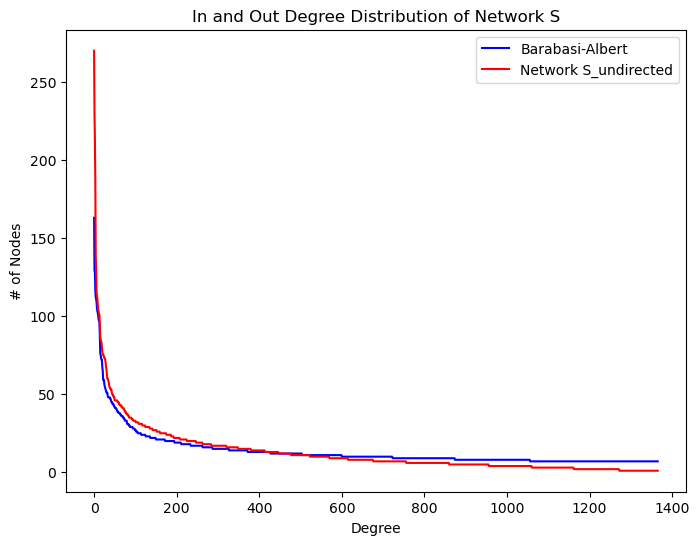

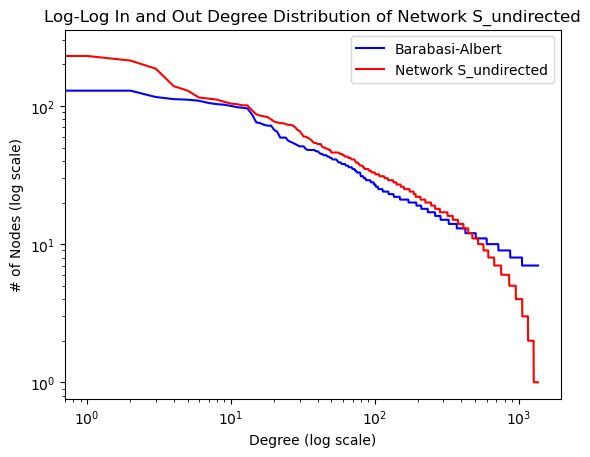

In [6]:
# Plotting the degree distributions
degree_sequence_F_BA = sorted([d for n, d in F_BA.degree()], reverse=True)
degree_sequence_S_undirected = sorted([d for n, d in S_undirected.degree()], reverse=True)

## Plot setup
plt.figure(figsize=(8, 6))

## Plotting the degree distribution as a linear plot
plt.plot(degree_sequence_F_BA, 'b-', label='Barabasi-Albert')
plt.plot(degree_sequence_S_undirected, 'r-', label='Network S_undirected')

plt.xlabel('Degree')
plt.ylabel('# of Nodes')
plt.title('In and Out Degree Distribution of Network S')
plt.legend()
plt.show()


## Plotting the degree distribution as a log-log plot
plt.loglog(degree_sequence_F_BA, 'b-', label='Barabasi-Albert')
plt.loglog(degree_sequence_S_undirected, 'r-', label='Network S_undirected')

plt.xlabel('Degree (log scale)')
plt.ylabel('# of Nodes (log scale)')
plt.title('Log-Log In and Out Degree Distribution of Network S_undirected')
plt.legend()
plt.show()

In [7]:
# Compute metrics for both graphs
wiki_metrics = compute_network_metrics(S_undirected)
ba_metrics = compute_network_metrics(F_BA)

# Compare metrics
print("Philosopher Wikipedia Graph Metrics:")
for key, value in wiki_metrics.items():
    if key not in ['degree_histogram', 'degree_centrality']:
        print(f"{key}: {value:.2f}")
        
print("\nBarabási-Albert Graph Metrics:")
for key, value in ba_metrics.items():
    if key not in ['degree_histogram', 'degree_centrality']:
        print(f"{key}: {value:.2f}")

Philosopher Wikipedia Graph Metrics:
global_clustering: 0.12
average_clustering: 0.28
assortativity: -0.11
num_connected_components: 1.00
largest_component_size: 1366.00
average_shortest_path: 3.04
diameter: 8.00

Barabási-Albert Graph Metrics:
global_clustering: 0.03
average_clustering: 0.04
assortativity: -0.03
num_connected_components: 1.00
largest_component_size: 1366.00
average_shortest_path: 2.82
diameter: 4.00


## Model Fitting

In [31]:
# Step 1: Extract the degree sequence
degrees = np.array([d for n, d in S_undirected.degree()])
print(f"Minimum degree: {np.min(degrees)}")
print(f"Maximum degree: {np.max(degrees)}")

# Step 2: Fit candidate distributions using MLE

# 2a. Poisson Distribution
lambda_poisson = np.mean(degrees)
log_likelihood_poisson = np.sum(poisson.logpmf(degrees, lambda_poisson))

# 2b. Exponential Distribution (continuous approximation)
params_exp = expon.fit(degrees, floc=0)  # Fix loc=0
lambda_exp = 1 / params_exp[1]  # Scale parameter is 1/lambda
log_likelihood_exp = np.sum(expon.logpdf(degrees, *params_exp))

# 2c. Log-Normal Distribution
params_lognorm = lognorm.fit(degrees[degrees > 0], floc=0)  # Exclude zeros
sigma_lognorm, loc_lognorm, scale_lognorm = params_lognorm
log_likelihood_lognorm = np.sum(lognorm.logpdf(degrees[degrees > 0], *params_lognorm))

# 2d. Power-Law Distribution
fit = powerlaw.Fit(degrees, xmin=1)
alpha_powerlaw = fit.power_law.alpha
xmin_powerlaw = fit.power_law.xmin
log_likelihood_powerlaw = fit.power_law.loglikelihoods(degrees).sum()

# Step 3: Compute AIC and BIC for each model
n = len(degrees)

# Poisson
k_poisson = 1  # lambda
AIC_poisson = 2 * k_poisson - 2 * log_likelihood_poisson
BIC_poisson = k_poisson * np.log(n) - 2 * log_likelihood_poisson

# Exponential
k_exp = 1  # lambda
AIC_exp = 2 * k_exp - 2 * log_likelihood_exp
BIC_exp = k_exp * np.log(n) - 2 * log_likelihood_exp

# Log-Normal
n_lognorm = len(degrees[degrees > 0])
k_lognorm = 2  # sigma and scale
AIC_lognorm = 2 * k_lognorm - 2 * log_likelihood_lognorm
BIC_lognorm = k_lognorm * np.log(n_lognorm) - 2 * log_likelihood_lognorm

# Power-Law
n_powerlaw = len(degrees[degrees >= xmin_powerlaw])
k_powerlaw = 2  # alpha and xmin
AIC_powerlaw = 2 * k_powerlaw - 2 * log_likelihood_powerlaw
BIC_powerlaw = k_powerlaw * np.log(n_powerlaw) - 2 * log_likelihood_powerlaw

# Step 4: Select the best-fitting model based on AIC and BIC
AICs = {
    'Poisson': AIC_poisson,
    'Exponential': AIC_exp,
    'Log-Normal': AIC_lognorm,
    'Power-Law': AIC_powerlaw
}

BICs = {
    'Poisson': BIC_poisson,
    'Exponential': BIC_exp,
    'Log-Normal': BIC_lognorm,
    'Power-Law': BIC_powerlaw
}

best_fit_aic = min(AICs, key=AICs.get)
best_fit_bic = min(BICs, key=BICs.get)

# Output results
print("\nModel fitting results:")
print("-----------------------")
print("Log-Likelihoods:")
print(f"-Poisson: {log_likelihood_poisson:.1f}")
print(f"-Exponential: {log_likelihood_exp:.1f}")
print(f"-Log-Normal: {log_likelihood_lognorm:.1f}")
print(f"-Power-Law: {log_likelihood_powerlaw:.1f}")

print(f"\nAIC values:")
for dist, aic in AICs.items():
    print(f"-{dist}: {aic:.2f} {'<- Best fit' if dist == best_fit_aic else ''}")

print(f"\nBIC Values:")
for dist, bic in BICs.items():
    print(f"-{dist}: {bic:.1f} {'<- Best fit' if dist == best_fit_bic else ''}")

print("\nEstimated parameters:")
print("---------------------")
print(f"Poisson lambda: {lambda_poisson:.2f}")
print(f"Exponential lambda: {lambda_exp:.4f}")
print(f"Log-Normal sigma: {sigma_lognorm:.4f}, scale: {scale_lognorm:.2f}")
print(f"Power-Law alpha: {alpha_powerlaw:.2f}, xmin: {xmin_powerlaw}")


Minimum degree: 1
Maximum degree: 270

Model fitting results:
-----------------------
Log-Likelihoods:
-Poisson: -12895.2
-Exponential: -4892.2
-Log-Normal: -4763.7
-Power-Law: -5100.4

AIC values:
-Poisson: 25792.30 
-Exponential: 9786.30 
-Log-Normal: 9531.48 <- Best fit
-Power-Law: 10204.88 

BIC Values:
-Poisson: 25797.5 
-Exponential: 9791.5 
-Log-Normal: 9541.9 <- Best fit
-Power-Law: 10215.3 

Estimated parameters:
---------------------
Poisson lambda: 13.22
Exponential lambda: 0.0757
Log-Normal sigma: 1.0421, scale: 7.59
Power-Law alpha: 1.49, xmin: 1.0


# Communities

In [1]:
import pickle
import os
import re
from wiki_utils import get_category_data
from network_utils import filter_graph_by_attribute, count_nodes_by_attribute
from community import community_louvain
import networkx as nx
import networkx.algorithms.community as nx_comm
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# load graph:
S = pickle.load(open(PICKLE_DIR + "/graph.pkl", "rb"))
S_undirected = pickle.load(open(PICKLE_DIR + "/graph_undirected.pkl", "rb"))

## Extraction using `subfields` and `tradition`

### (A) Extracting `subfield`
From https://en.wikipedia.org/wiki/Lists_of_philosophers

#### (A.1) Fetching data
Two options are below either
- `Option 1`: Fetching data anew from Wikipedia
- `Option 2`: Using pickle file from last time option 1 was run

In [ ]:
subfield_links = [
		"List of aestheticians",
		"List of critical theorists",
		"List of environmental philosophers",
		"List of epistemologists",
		"List of ethicists",
		"List of existentialists",
		"List of feminist philosophers",
		"List of secular humanists", #List of Humanists redirect
		"List of logicians",
		"List of metaphysicians",
		"Index of sociopolitical thinkers", #List of Social and Political Philosophers redirect
		"List of phenomenologists",
		"List of philosophers of language",
		"List of philosophers of mind",
		"List of philosophers of religion",
		"List of philosophers of science",
		"List of political philosophers",
		"List of political theorists",
		"List of rationalists",
		"List of utilitarians"
]

##### -> `Option 1`: **Fetch the data from Wikipedia** (takes around 5 seconds)

In [ ]:
replace_terms_subfields = [("List of", ""), ("Index of", "")]
clean_subfield_data, philosopher_subfield_info = get_category_data(
    subfield_links, replace_terms_subfields, verbose=True
)
pickle.dump(philosopher_subfield_info, open(PICKLE_DIR + "/philosopher_subfield_info.pkl", "wb")) # Saved as local version for later use

print("Total =", len(philosopher_subfield_info))

- aestheticians: 86
- critical theorists: 107
- environmental philosophers: 80
- epistemologists: 122
- ethicists: 287
- existentialists: 60
- feminist philosophers: 134
- secular humanists: 413
- logicians: 291
- metaphysicians: 185
- sociopolitical thinkers: 245
- phenomenologists: 24
- philosophers of language: 141
- philosophers of mind: 140
- philosophers of religion: 110
- philosophers of science: 111
- political philosophers: 199
- political theorists: 137
- rationalists: 27
- utilitarians: 104
Total = 2183


##### -> `Option 2`: **Use local pickle file** from last time option 1 was run

In [ ]:
philosopher_subfield_info = pickle.load(open(PICKLE_DIR + "/philosopher_subfield_info.pkl", "rb"))

#### (A.2) Creating `S.subfields` network

In [ ]:
S_subfields = filter_graph_by_attribute(
    graph=S_undirected,
    attribute_info=philosopher_subfield_info,
    attribute_name='subfields',
    verbose=True
)
print("-"*50)
count_nodes_by_attribute(S_subfields, 'subfields', verbose=True)
print("-"*50)


Did not find subfields for: 771 philosophers (therefore not included in the filtered graph)
 -> Example of removed nodes: ['John_Selden', 'John_Maynard_Keynes', 'Thomas_of_York_(Franciscan)']
Original graph: 1366 nodes and 9023 edges
Filtered 'subfields' graph: 595 nodes and 4232 edges
--------------------------------------------------
Number of nodes by subfields:
 -> epistemologists: 78
 -> ethicists: 115
 -> philosophers of religion: 49
 -> logicians: 89
 -> metaphysicians: 119
 -> philosophers of language: 68
 -> sociopolitical thinkers: 131
 -> philosophers of mind: 57
 -> utilitarians: 29
 -> political philosophers: 135
 -> aestheticians: 51
 -> existentialists: 7
 -> feminist philosophers: 23
 -> political theorists: 73
 -> philosophers of science: 45
 -> critical theorists: 41
 -> secular humanists: 34
 -> phenomenologists: 11
 -> rationalists: 17
 -> environmental philosophers: 8
--------------------------------------------------


### (B) Using `tradition` (western/eastern divide)

#### (B.1) Extracting information from wikipedia

Two options are below either
- `Option 1`: Fetching data anew from Wikipedia
- `Option 2`: Using pickle file from last time option 1 was run

##### -> `Option 1`: Extract from wikipedia

In [ ]:
tradition_links = [
	"Timeline of Eastern philosophers",
	"Timeline of Western philosophers"
]

replace_terms_traditions = [("Timeline of", "")]
clean_tradition_data, philosopher_tradition_info = get_category_data(
    tradition_links, replace_terms_traditions, verbose=True
)
pickle.dump(philosopher_tradition_info, open(PICKLE_DIR + "/philosopher_tradition_info.pkl", "wb")) # Saved as local version for later use
print("Total =", len(philosopher_tradition_info))

- Eastern philosophers: 343
- Western philosophers: 565
Total = 893


##### -> `Option 2`: **Use local pickle file** from last time option 1 was run

In [ ]:
philosopher_tradition_info = pickle.load(open(PICKLE_DIR + "/philosopher_tradition_info.pkl", "rb"))

#### (B.2) Creating `S_tradition` network

In [ ]:
S_tradition = filter_graph_by_attribute(
    graph=S_undirected,
    attribute_info=philosopher_tradition_info,
    attribute_name='tradition',
    verbose=True
)

print("-"*50)
count_nodes_by_attribute(S_tradition, 'tradition', verbose=True)
print("-"*50)

Did not find tradition for: 1020 philosophers (therefore not included in the filtered graph)
 -> Example of removed nodes: ['John_Selden', 'John_Maynard_Keynes', 'Thomas_of_York_(Franciscan)']
Original graph: 1366 nodes and 9023 edges
Filtered 'tradition' graph: 346 nodes and 2562 edges
--------------------------------------------------
Number of nodes by tradition:
 -> Western philosophers: 279
 -> Eastern philosophers: 69
--------------------------------------------------


## Partitioning

### Imports and definitions

In [ ]:
from community import community_louvain
import networkx as nx
import networkx.algorithms.community as nx_comm
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans

def create_partition_using_attribute(graph, attribute_name):
	partition = {}
	for node, data in graph.nodes(data=True):
		attribute = data.get(attribute_name)
		if isinstance(attribute, list):
			attribute = attribute[0]
		if attribute is not None:
				partition[node] = attribute
	return partition

def get_louvain_modularity(graph, partition_dict):
	return f"{community_louvain.modularity(partition_dict, graph):.4f}"

def plot_partition_heatmap(graph, attribute_partition, louvain_partition, attribute_name, top_n=7, title="Confusion Matrix"):
    """
    Plots a confusion matrix heatmap comparing attribute-based partition and Louvain community partition.

    Args:
        graph (networkx.Graph): The graph to analyze.
        attribute_partition (dict): Partition mapping nodes to their attributes.
        louvain_partition (dict): Louvain partition mapping nodes to communities.
        attribute_name (str): Name of the attribute (e.g., 'subfields' or 'tradition').
        top_n (int): Number of top attributes and communities to consider for the heatmap.
        title (str): Title of the heatmap.
    """
    # Step 1: Identify top attributes and communities
    attribute_counts = Counter(attribute_partition.values())
    top_attributes = [attribute for attribute, _ in attribute_counts.most_common(top_n)]

    community_counts = Counter(louvain_partition.values())
    top_communities = [community for community, _ in community_counts.most_common(top_n)]

    # Step 2: Map attributes and communities to matrix indices
    attribute_to_index = {attribute: idx for idx, attribute in enumerate(top_attributes)}
    community_to_index = {community: idx for idx, community in enumerate(top_communities)}

    # Step 3: Initialize confusion matrix D
    D = np.zeros((top_n, top_n), dtype=int)

    # Step 4: Populate the confusion matrix
    for node in graph.nodes:
        attribute = attribute_partition.get(node)  # Get node's attribute
        community = louvain_partition.get(node)  # Get node's Louvain community

        # Only consider top attributes and communities
        if community in community_to_index and attribute in attribute_to_index:
            i = attribute_to_index[attribute]
            j = community_to_index[community]
            D[i, j] += 1

    # Step 5: Create the heatmap
    plt.figure(figsize=(7, 7))
    plt.imshow(D, interpolation='nearest', cmap='Blues')

    # Add text annotations for each cell
    for i in range(D.shape[0]):
        for j in range(D.shape[1]):
            plt.text(j, i, int(D[i, j]), ha="center", va="center", color="black")

    # Add titles, labels, and ticks
    plt.title(title)
    plt.xlabel('Communities')
    plt.ylabel(f'{attribute_name.capitalize()}')

    # Set tick labels
    plt.xticks(np.arange(len(top_communities)), [f"C {c}" for c in top_communities])
    plt.yticks(np.arange(len(top_attributes)), top_attributes)

    # Add a color bar
    plt.colorbar()
    plt.show()

### (A) Partitioning using `S_subfields`

Each node is characterized by the first `subfield` if there are multiple.

In [ ]:
subfields_partition = create_partition_using_attribute(S_subfields, 'subfields')
subfields_partition_modularity = get_louvain_modularity(S_subfields, subfields_partition)
print("Subfields partion Modularity = ", subfields_partition_modularity)

louvain_partition_S_subfields = community_louvain.best_partition(S_subfields, random_state=RANDOM_STATE)
print("Louvain partion Modularity = ", get_louvain_modularity(S_subfields, louvain_partition_S_subfields))

# louvain_partition_S_subfields_kmeans = louvain_kmeans_partition(S_subfields, len(subfield_links))
# print("Louvain partion (with KMeans community limit) Modularity = ", get_louvain_modularity(S_subfields, louvain_partition_S_subfields_kmeans))

Subfields partion Modularity =  0.0874
Louvain partion Modularity =  0.4280


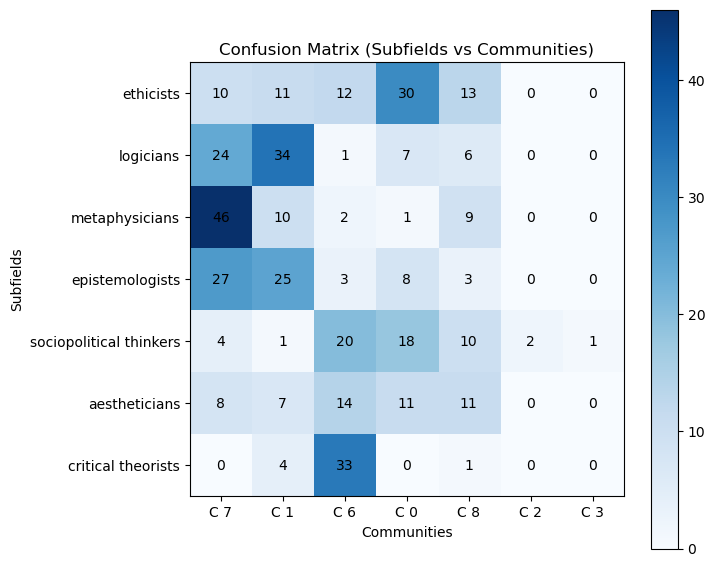

In [ ]:
plot_partition_heatmap(
    graph=S_subfields,
    attribute_partition=subfields_partition,
    louvain_partition=louvain_partition_S_subfields,
    attribute_name='subfields',
    title='Confusion Matrix (Subfields vs Communities)'
)

### (B) Partitioning using `S_tradition`

In [ ]:
tradition_partition = create_partition_using_attribute(S_tradition, 'tradition')
tradition_partition_modularity = get_louvain_modularity(S_tradition, tradition_partition)

print("Tradition partion Modularity = ", tradition_partition_modularity)

louvain_partition_S_tradition = community_louvain.best_partition(S_tradition, random_state=RANDOM_STATE)
print("Louvain partion Modularity = ", get_louvain_modularity(S_tradition, louvain_partition_S_tradition))

# louvain_partition_S_tradition_kmeans = louvain_kmeans_partition(S_tradition, 2)
# print("Louvain partion (with KMeans community limit) Modularity = ", get_louvain_modularity(S_tradition, louvain_partition_S_tradition_kmeans))

Tradition partion Modularity =  0.0802
Louvain partion Modularity =  0.3973


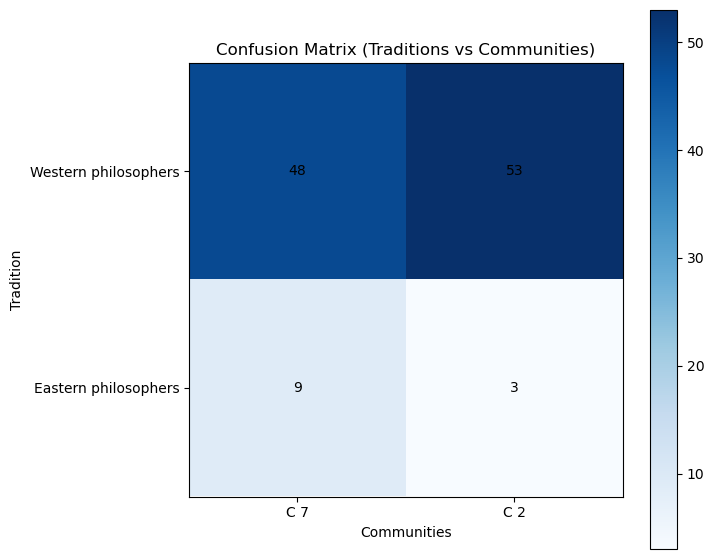

In [ ]:
plot_partition_heatmap(
    graph=S_tradition,
    attribute_partition=tradition_partition,
    louvain_partition=louvain_partition_S_tradition,
    attribute_name='tradition',
    top_n=2,
	title='Confusion Matrix (Traditions vs Communities)'
)

# Network Metrics for communities

## (A) Community `subfields`

## (B) Community `tradition`

#